In [1]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

from scipy.stats import multivariate_normal 
from scipy.stats import invwishart 

from sklearn import metrics
from scipy.special import psi
from scipy.special import digamma 


In [2]:
random_seed = 123
rng = np.random.default_rng(random_seed)

## Mean Field 

Mean Field (Structured) Independence Simplifying Assumption
$$
    q(\boldsymbol{\pi},\boldsymbol{\phi},\mathbf{z}) = 
        \underbrace{q(\boldsymbol{\pi})}_{\text{Dirichlet}}
        \underbrace{q(\boldsymbol{\phi})}_{\text{Beta}}
        \underbrace{q(\mathbf{z})}_{\text{Cat}}
$$

Update Steps 

$$\begin{align}
    &\log q(\boldsymbol{\phi},\boldsymbol{\Sigma},\boldsymbol{\pi}) = \Big\langle \log p(\mathbf{z},\mu,\mathbf{X}) \Big\rangle_{q(\mathbf{z})}  + \text{const}\\\\
    
    &\log q(\mathbf{z}) = \Big\langle \log p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}) \Big\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}
\end{align}$$

Posterior
$$
    p(\mathbf{X},\boldsymbol{\phi},\mathbf{z},\boldsymbol{\pi}) \propto p(\mathbf{X}|\boldsymbol{\phi},\mathbf{z})p(\boldsymbol{\phi})p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi})
$$

## Update for model parameters $p(\mu,\pi)$

$$\begin{align}
    \ln q(\boldsymbol{\phi},\boldsymbol{\pi}) &= \Big\langle \ln p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}_H,\mathbf{X}_O) \Big\rangle_{q(\mathbf{z})} + \text{const}\\\\

    &= \Big\langle \ln p(\mathbf{X}_O,\mathbf{X}_H|\boldsymbol{\phi}, \mathbf{z}) \Big\rangle_{q(\mathbf{z})} + 
       \Big\langle \ln p(\boldsymbol{\phi}) \Big\rangle_{q(\mathbf{z})} + 
        \Big\langle \ln p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} +
       \text{const}\\\\

    &=  \underbrace{\Big\langle \ln p(\mathbf{X}_O,\mathbf{X}_H|\boldsymbol{\phi}, \mathbf{z}) \Big\rangle_{q(\mathbf{z})} + 
        \ln p(\boldsymbol{\phi})}_{\text{Terms containing $\boldsymbol{\phi}$}} + 
       \underbrace{
            \Big\langle \ln p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + 
            \ln p(\boldsymbol{\pi}) 
       }_{\text{\text{Terms containing $\boldsymbol{\pi}$}}} +
       \text{const}\\\\
\end{align}$$




#### Update Step for $q(\boldsymbol{\pi})$

$$\begin{align}
    \log q(\boldsymbol{\pi}) &= \log p(\boldsymbol{\pi}) + \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &= \log \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0) + \Big\langle \sum_n^N \log p(z_n|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &= \log \Big[ \frac{1}{B(\alpha_0)}\prod_k^K \pi_k^{\alpha_0 - 1} \Big] + \Big\langle \sum_n^N \sum_k^K \log \pi_{k}^{z_{nk}} \Big\rangle_{q(\mathbf{z})} + \text{const} \\
       
    &= \underbrace{-\log B(\alpha_0)}_{\text{Independent of $\pi$}} + \sum_k^K \log \pi_k^{\alpha_0 - 1} +
       \Big\langle \sum_k^K \sum_n^N z_{nk}\log \pi_{k} \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &=   \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N \Big\langle z_{nk} \Big\rangle_{q(\mathbf{z})} \log \pi_{k} + \text{const}, \quad -\log B(\alpha_0) \text{ absorbed into const}\\

    &= \sum_k^K (\alpha_0 - 1) \log \pi_k + \sum_k^K \sum_n^N r_{nk} \log \pi_{k} + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 - 1) \log \pi_k + \log \pi_{k} \sum_n^N r_{nk} \Big] + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 + N_k -1) \log \pi_k  \Big] + \text{const}, \quad \text{where } N_k = \sum_n^N r_{nk} \\

    \implies & \boxed{q(\boldsymbol{\pi}) = \prod_k^K \pi_k^{\alpha_0 + N_k - 1} + \text{const} = \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0 + N), \quad \text{where } N = [N_0,...,N_K]}\\
\end{align}$$

#### Update step for $q(\boldsymbol{\phi})$


$$\begin{align}
    \log q(\boldsymbol{\phi}) &= \Big\langle \log p(\mathbf{X}|\boldsymbol{\phi}, \mathbf{z}) \Big\rangle_{q(\mathbf{z})} + \log p(\boldsymbol{\phi}) + \text{const}\\\\

    &= \sum_k^K \log p(\boldsymbol{\phi}_k) + \Big\langle \sum_n^N \sum_k^K \log p(\mathbf{x}_n|\boldsymbol{\phi}_k)^{z_{nk}} \Big\rangle_{q(\mathbf{z})}  + \text{const}\\\\

    &= \sum_k^K \log p(\boldsymbol{\phi}_k) + \Big\langle \sum_n^N \sum_k^K z_{nk} \cdot \log p(\mathbf{x}_n|\boldsymbol{\phi}_k) \Big\rangle_{q(\mathbf{z})}  + \text{const}\\\\

    &= \sum_k^K \log p(\boldsymbol{\phi}_k) +  \sum_n^N \sum_k^K \langle z_{nk} \rangle_{q(\mathbf{z})}  \cdot \log p(\mathbf{x}_n|\boldsymbol{\phi}_k)   + \text{const}\\\\

    &= \sum_k^K \log p(\boldsymbol{\phi}_k) +  \sum_n^K \sum_k^K r_{nk}  \cdot \log p(\mathbf{x}_n|\boldsymbol{\phi}_k)   + \text{const}\\\\


    &= \sum_k^K  \Bigg[ \log p(\boldsymbol{\phi}_k) + \sum_n^N  r_{nk}  \cdot \log p(\mathbf{x}_n|\boldsymbol{\phi}_k)  \Bigg]  + \text{const}\\\\

    \implies & \log q(\boldsymbol{\phi}) = \sum_k^K \log q(\boldsymbol{\phi}_k)
\end{align}$$

Hence with $\boldsymbol{\phi} = \{\boldsymbol{\mu}\}$,
$$\begin{align}
    \log q(\boldsymbol{\mu}_k) &= \log p(\boldsymbol{\mu}_k) + \sum_n^N  r_{nk}  \cdot \log p(\mathbf{x}_n|\boldsymbol{\mu}_k) + \text{const}\\\\

    &= \log \mathcal{Beta}(\mu_k|\mathbf{a}_{0},\mathbf{b}_{0}) + 
        \sum_n^N  r_{nk}  \cdot \log \mathcal{Bern}(\mathbf{x}_n|\boldsymbol{\mu}_k) +
        \text{const}\\\\

    &= \sum_d^D \log \mathcal{Beta}(\mu_{k,d}|\mathbf{a}_{0,d},\mathbf{b}_{0,d}) + 
       + \sum_n^N  r_{nk}  \cdot \sum_d^D \log \mathcal{Bern}(x_{n,d}|\boldsymbol{\mu}_{k,d}) +
        \text{const}\\\\

    \implies \log q(\mu_{k,d}) &= \log \mathcal{Beta}(\mu_{k,d}|\mathbf{a}_{0,d},\mathbf{b}_{0,d}) + \sum_n^N r_{nk}  \cdot \log
        \mathcal{Bern}(x_{n,d}|\boldsymbol{\mu}_{k,d}) + \text{const}\\\\

    &= (a_{0,d} - 1)\log\mu_{k,d} + (b_{0,d} - 1)\log(1 - \mu_{k,d}) + \sum_n^N r_{nk} \cdot \Big(x_{n,d} \log\mu_{k,d} + (1 - x_{n,d})\log(1 - \mu_{k,d})\Big) + \text{const}\\\\

    &= (a_{0,d} - 1)\log\mu_{k,d} + (b_{0,d} - 1)\log(1 - \mu_{k,d})
        + \sum_n^N r_{nk} \cdot x_{n,d} \log\mu_{k,d} 
        + \sum_n^N r_{nk} \cdot (1 - x_{n,d})\log(1 - \mu_{k,d})
        + \text{const}\\\\

    &= (a_{0,d} - 1)\log\mu_{k,d} + (b_{0,d} - 1)\log(1 - \mu_{k,d})
        +  \log\mu_{k,d} \sum_n^N r_{nk} \cdot x_{n,d}
        + \log(1 - \mu_{k,d}) \sum_n^N r_{nk} \cdot (1 - x_{n,d})
        + \text{const}\\\\

    &= \Big(a_{0,d} + \sum_n^N r_{nk} x_{n,d} - 1\Big)\log\mu_{k,d} + 
       \Big(b_{0,d} +  \sum_n^N r_{nk}(1 - x_{n,d}) - 1 \Big)\log(1 - \mu_{k,d})
        + \text{const}\\\\
\end{align}$$

This is the form of a Beta distribution, hence

$$\begin{align}
    q(\mu_{k,d}) &= \mathcal{Beta}(a_{kd},b_{kd}), \quad \text{where }\\ 
        &a_{kd} = a_{0,d} + \sum_n^N r_{nk} x_{n,d}\\
        &b_{kd} = b_{0,d} +  \sum_n^N r_{nk}(1 - x_{n,d})
\end{align}$$

#### Update step for $q(\mathbf{z})$
$$\begin{align}
    \log q(\mathbf{z}) &= \Big\langle \log p(\mathbf{X},\boldsymbol{\phi},\boldsymbol{\pi}) \Big\rangle_{q(\mu,\pi)} + \text{const}\\\\

    &= \Big\langle \log p(\mathbf{X}|\boldsymbol{\phi}) \Big\rangle_{q(\mu,\pi)} + 
       \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mu,\pi)} + 
       \underbrace{\log p(\boldsymbol{\phi}) + \log p(\boldsymbol{\pi})}_{\text{Independent of } \mathbf{z}} + 
       \text{const}\\\\

    &= \Big\langle \log p(\mathbf{X}|\boldsymbol{\phi}) \Big\rangle_{q(\mu,\pi)} + 
       \Big\langle \log p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mu,\pi)} + 
       \text{const}\\\\

    &= \Big\langle \sum_n^N \sum_k^K \log p(\mathbf{x}_n|\boldsymbol{\phi}_k)^{z_{nk}} \Big\rangle_{q(\mu,\pi)} + 
       \Big\langle \sum_n^N \sum_k^K \log p(z_n = k|\boldsymbol{\pi})^{z_{nk}} \Big\rangle_{q(\mu,\pi)} + 
       \text{const}\\\\

    &= \Big\langle \sum_n^N \sum_k^K z_{nk} \log p(\mathbf{x}_n|\boldsymbol{\phi}_k) \Big\rangle_{q(\mu,\pi)} + 
       \Big\langle \sum_n^N \sum_k^K z_{nk} \log p(z_n = k|\boldsymbol{\pi}) \Big\rangle_{q(\mu,\pi)} + 
       \text{const}\\\\

    &= \sum_n^N \sum_k^K \Big\langle  z_{nk} \log p(\mathbf{x}_n|\boldsymbol{\phi}_k) \Big\rangle_{q(\mu,\pi)} + 
       \sum_n^N \sum_k^K \Big\langle z_{nk} \log p(z_n = k|\boldsymbol{\pi}) \Big\rangle_{q(\mu,\pi)} + 
       \text{const}\\\\

    &= \sum_n^N \Bigg[ \sum_k^K \Big\langle  z_{nk} \log p(\mathbf{x}_n|\boldsymbol{\phi}_k) \Big\rangle_{q(\mu,\pi)} + 
       \sum_k^K \Big\langle z_{nk} \log p(z_n = k|\boldsymbol{\pi}) \Big\rangle_{q(\mu,\pi)} \Bigg] + 
       \text{const}\\\\

    \implies & \log q(\mathbf{z}) = \sum_n^N \log q(z_n)
\end{align}$$
Hence
$$\begin{align}
    \log q(z_n) &= \sum_k^K \Big\langle  z_{nk} \log p(\mathbf{x}_n|\boldsymbol{\phi}_k) \Big\rangle_{q(\mu,\pi)} + 
       \sum_k^K \Big\langle z_{nk} \log p(z_n = k|\boldsymbol{\pi}) \Big\rangle_{q(\mu,\pi)}  + \text{const}\\\\

    &= \sum_k^K  \Bigg[ 
        \Big\langle  z_{nk} \log p(\mathbf{x}_n|\boldsymbol{\phi}_k) \Big\rangle_{q(\mu,\pi)} +
        \Big\langle z_{nk} \log p(z_n = k|\boldsymbol{\pi}) \Big\rangle_{q(\mu,\pi)}
    \Bigg] +  \text{const}

\end{align}$$

This gives
$$
    \log p(z_n=k) = \underbrace{\Big\langle \log p(\mathbf{x}_n|\boldsymbol{\phi}_k) \Big\rangle_{q(\mu,\pi)}}_{(1)} +
        \underbrace{\Big\langle \log \boldsymbol{\pi}_k \Big\rangle_{q(\mu,\pi)}}_{(2)} + \text{const}
$$

For mixed-bern $\boldsymbol{\phi} = \{\boldsymbol{\mu}\}$. Hence,

$$\begin{align}
    (1) \quad \Big\langle \log p(\mathbf{x}_n|\boldsymbol{\phi}_k) \Big\rangle_{q(\mu)} &= \Big\langle \log \mathcal{Bern}(\mathbf{x}_n|\boldsymbol{\mu}_k) \Big\rangle_{q(\mu)}\\\\

    &= \Big\langle \sum_d^D \log \mathcal{Bern}(x_{n,d}|\mu_{k,d}) \Big\rangle_{q(\mu)}\\\\

    &= \Big\langle \sum_d^D x_{n,d}\log\mu_{k,d} + (1 - x_{n,d})\log(1 - \mu_{k,d})\Big\rangle_{q(\mu)}\\\\

    &= \sum_d^D x_{n,d}  \big\langle \log\mu_{k,d}\big\rangle_{q(\mu)} + (1 - x_{n,d})\big\langle \log(1 - \mu_{k,d})\big\rangle_{q(\mu)}\\\\

    &= \sum_d^D x_{n,d} \Big(\psi(a_{k,d}) - \psi(a_{k,d} + b_{k,d}) \Big) + (1 - x_{n,d}) \Big( \psi(b_{k,d}) - \psi(a_{k,d} + b_{k,d}) \Big)
\end{align}$$

For (2), given that each marginal of a Dirichlet distribution is a Beta distribution with : $\boldsymbol{\pi}_k \sim \text{Beta}(\alpha_k, \sum_{k'}\alpha_{k'}-\alpha_k)$  
And that if $X\sim\text{Beta}(a,b)$, then $\mathbb{E}[\log X] = \psi(a) - \psi(a + b)$
$$\begin{align}
    (2) \quad \mathbb{E}_{q(\boldsymbol{\pi})}\Big[ \log \boldsymbol{\pi}_{k} \Big] = \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big)
\end{align}$$

Hence we get the update step : 

$$\begin{align}
    \log q(z_n=k) &= \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) + 
                     \sum_d^D \Bigg[x_{n,d} \big(\psi(a_{k,d}) - \psi(a_{k,d} + b_{k,d}) \big) + (1 - x_{n,d}) \big( \psi(b_{k,d}) - \psi(a_{k,d} + b_{k,d}) \big)\Bigg] +
                     \text{const}\\\\
\end{align}$$

# Implementation

In [3]:
def update_Θ(X,R,a_0,b_0,K):
    N,D = X.shape

    a = np.zeros((K,D))
    b = np.zeros((K,D))

    for k in range(K):
        a[k,:] = a_0[k,:] + (R[:,k].T @ X)
        b[k,:] = b_0[k,:] + (R[:,k].T @ (1 - X))

    return a,b

In [4]:
def bernoulli_logprob(X,a,b,K):
    N,D = X.shape 

    logprob = np.zeros((N,K))

    for k in range(K):
        logprob[:,k] = X @ (digamma(a[k,:]) - digamma(a[k,:] + b[k,:])) + (1 - X) @ (digamma(b[k,:]) - digamma(a[k,:] + b[k,:]))

    return logprob

In [5]:
def update_π(R,α_0):
    αs = α_0 + np.sum(R, axis=0) 

    return αs

In [6]:
def update_z(X,dataLogProb,α,πs,K,mode=0):
    N,D = X.shape

    R = np.zeros((N,K))

    α_sum = psi(np.sum(α))

    for k in range(K):
        logprior = psi(α[k]) - α_sum

        R[:,k] = dataLogProb[:,k].copy()

        if mode == 0:
            R[:,k] += logprior
        elif mode == 1:
            R[:,k] += np.log(πs[k])

    log_norm = logsumexp(R,axis=1,keepdims=True)

    R = np.exp(R - log_norm)

    loglik = np.sum(log_norm) / N

    return R,loglik   

In [7]:
def meanfield_vi(X,K,mode=0,max_iters=100,tol=1e-4):
    N,D = X.shape

    α_0 = np.full(K, 1, dtype=np.float64)
    a_0  = np.full((K, D), 1) # Beta
    b_0  = np.full((K, D), 1) # Beta

    a = a_0.copy()+ rng.gamma(1.0, 0.1, size=(K, D))
    b = b_0.copy()+ rng.gamma(1.0, 0.1, size=(K, D))
    α = α_0.copy()
    πs = rng.dirichlet(alpha=α)

    loglikes = []

    for t in range(max_iters):
        dataLogProb = bernoulli_logprob(X, a,b,K)
        R,loglike = update_z(X,dataLogProb,α,πs,K,mode=mode)

        α = update_π(R,α_0)
        a,b = update_Θ(X,R,a_0,b_0,K)

        loglikes.append(loglike)

        if t > 1 and np.abs(loglikes[t] - loglikes[t-1]) < tol:
            break

    return R, a, b, α, loglikes

## Evaluation

In [8]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

In [9]:
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

In [11]:
R, a, b, α, loglikes = meanfield_vi(X_mnist_train, 10,mode=0)
zs = np.argmax(R,axis=1)
metrics.adjusted_rand_score(Y_mnist_train, zs)

0.38683192534854677

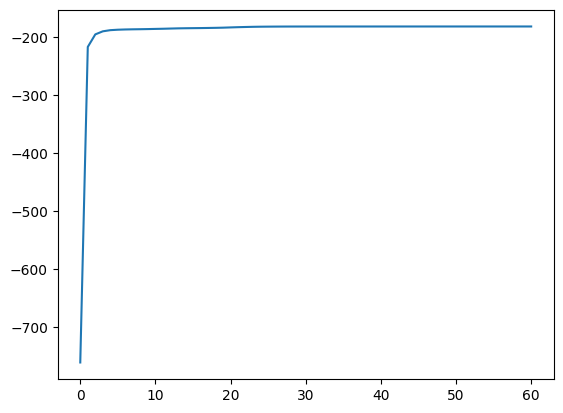

In [28]:
plt.plot(loglikes)

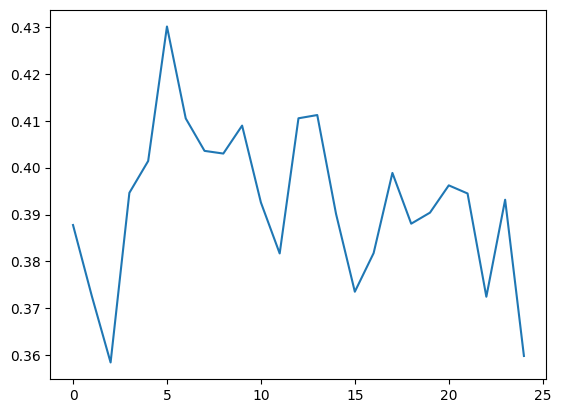

In [12]:
scores = []
for i in range(0,25):
    R, a, b, α, loglikes = meanfield_vi(X_mnist_train, 10,mode=0)
    zs = np.argmax(R,axis=1)
    scores.append(metrics.adjusted_rand_score(Y_mnist_train, zs))

plt.plot(scores)
plt.show()